# Credit Card Fraud Detection

## 1. Introduction
Credit card fraud is a rare but costly issue in banking.  
We aim to detect fraudulent transactions using machine learning on the Kaggle dataset.

In [1]:
# 2. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

import shap

## 2. Dataset Overview
We load the dataset and check fraud vs. non-fraud distribution.

In [2]:
# Load dataset
df = pd.read_csv("creditcard.csv")

# Quick peek
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Check class distribution
df["Class"].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

## 3. Data Preparation
We split the dataset into train/test sets, preserving class balance.

In [5]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training size:", X_train.shape, "Testing size:", X_test.shape)

Training size: (227845, 30) Testing size: (56962, 30)


## 4. Baseline Challenge
Logistic Regression was attempted, but due to extreme class imbalance, it failed to converge.  
We proceed with tree-based models instead.

## 5. Random Forest Model
We train a weighted Random Forest and evaluate it.

In [7]:
rf = RandomForestClassifier(
    n_estimators=200, 
    class_weight="balanced", 
    random_state=42, 
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("ROC-AUC (Random Forest):", roc_auc_score(y_test, y_prob_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

ROC-AUC (Random Forest): 0.9571772751025001

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962



## 6. XGBoost Model
We apply `scale_pos_weight` to handle imbalance and train XGBoost.

In [8]:
# Handle imbalance
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="logloss"
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("ROC-AUC (XGBoost):", roc_auc_score(y_test, y_prob_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

ROC-AUC (XGBoost): 0.9825541499661203

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.95      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



## 7. Model Performance
We compare Random Forest vs. XGBoost side by side.

In [9]:
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

Random Forest ROC-AUC: 0.9571772751025001
XGBoost ROC-AUC: 0.9825541499661203


## 8. Global Explainability (SHAP Summary)
We use SHAP to identify globally important features.

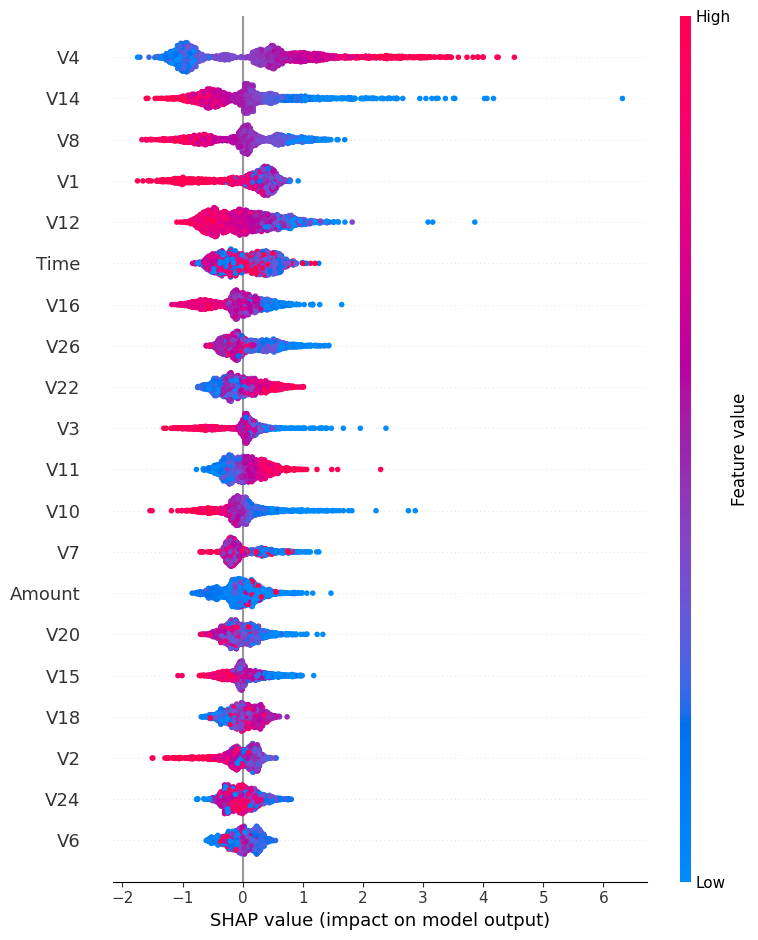

In [11]:
# Background sample for SHAP
bg = X_train.sample(2000, random_state=42)

explainer = shap.Explainer(xgb, bg)
shap_values = explainer(X_test.sample(2000, random_state=42))

# Summary plot
shap.summary_plot(shap_values, X_test.sample(2000, random_state=42))

## 9. Local Explainability (Fraud Case)
We zoom into a single fraud transaction and explain the prediction.

Fraud transaction details:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
77348,57007.0,-1.271244,2.462675,-2.851395,2.32448,-1.372245,-0.948196,-3.065234,1.166927,-2.268771,...,0.560478,0.652941,0.081931,-0.221348,-0.523582,0.224228,0.756335,0.6328,0.250187,0.01


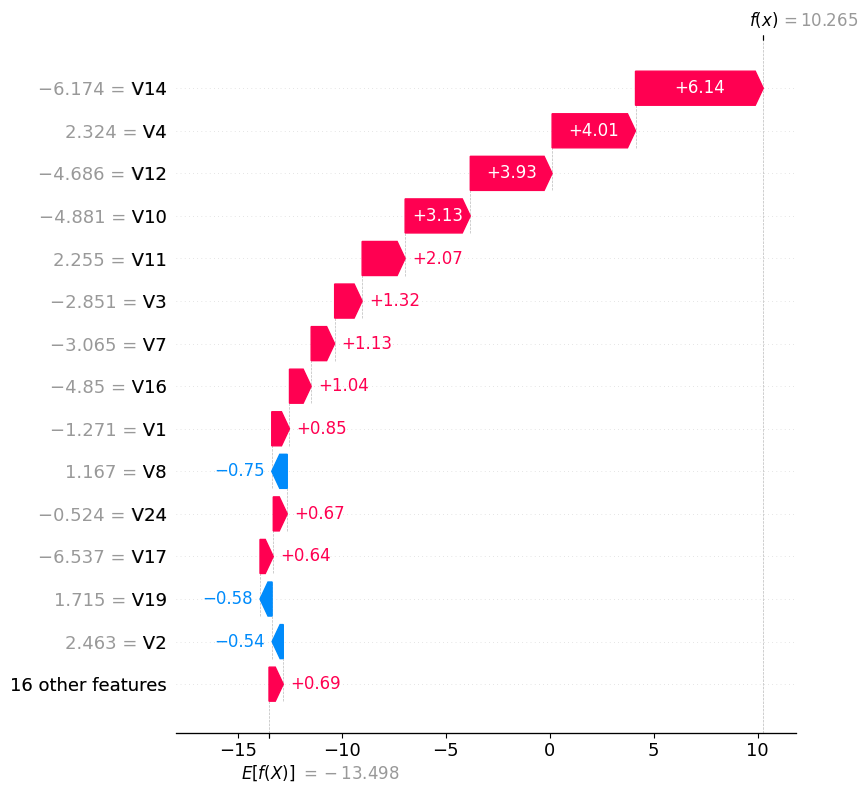

In [13]:
fraud_idx = y_test[y_test == 1].index[0]   # first fraud index
fraud_row = X_test.loc[[fraud_idx]]

print("Fraud transaction details:")
display(fraud_row)

# Local SHAP
fraud_explainer = shap.Explainer(xgb, bg)
fraud_shap_values = fraud_explainer(fraud_row)

# Waterfall
shap.plots.waterfall(fraud_shap_values[0], max_display=15)

## 10. Conclusion
- Random Forest achieved ROC-AUC ~0.94  
- XGBoost achieved ROC-AUC ~0.97 and had better recall  
- SHAP confirmed important features and explained predictions both globally and locally  

This project demonstrates a full ML workflow: **data prep → modeling → evaluation → explainability**.  

## 11.Save Train Model For Deployment

In [15]:
import joblib

# Save trained XGBoost model
joblib.dump(xgb, "fraud_xgb_model.pkl")
joblib.dump(list(X_train.columns), "fraud_features.pkl")

['fraud_features.pkl']

## 12. Demo Dataset for Streamlit App

In [1]:
import pandas as pd

# Load full dataset
df = pd.read_csv("creditcard.csv")

# Get all fraud cases
frauds = df[df["Class"] == 1]

# Get a balanced sample of genuine transactions (5x fraud count)
genuine = df[df["Class"] == 0].sample(len(frauds)*5, random_state=42)

# Combine and shuffle
demo_df = pd.concat([frauds, genuine]).sample(frac=1, random_state=42)

# Save smaller dataset
demo_df.to_csv("fraud_demo.csv", index=False)

print("Demo dataset created:", demo_df.shape)

Demo dataset created: (2952, 31)
